## Convex setting - Quadratic case
**Quick recall **

Let us consider the NAG block Matrix: \\

$G_{NAG}=\begin{bmatrix} -I & I \\ \mu/\gamma-A/\gamma & -\mu/\gamma I \end{bmatrix}$ where:
1.   $A$ is the positive definite matrix of size $n$-by-$n$ defining the objective function $f(x)=\frac{1}{2}x^T A x$.
2.   $\frac{d\gamma}{dt}=\mu-\gamma$, $\gamma(0)=\gamma_0 > 0$.

Let $y=(x,v)$, we consider the dynamical system:

$\frac{dy}{dt}=Gy$ with $y(0)=y_0 \in \mathbb{R}^{2n}$. 

which can be equivalently written as follows:

$$
\begin{split}
&\frac{dx}{dt} = v - x, \\
&\frac{dv}{dt} = \frac{\mu}{\gamma} (v - x) - \frac{1}{\gamma} A x.
\end{split} 
$$

Before going further, let us remark that this linear ODE can be expressed as the following second-order ODE by elimitating $v$:

$\gamma \frac{d^2 x}{dt^2} + (\gamma + \mu) \frac{d x}{dt} + Ax = 0$.
where $Ax$ is thefore the gradient of $f$ w.r.t. $x$.

Let us model the noise from the input gradient as follows:

$$
\begin{split}
&\frac{dx}{dt} = v - x, \\
&\frac{dv}{dt} = \frac{\mu}{\gamma} (x - v) - \frac{1}{\gamma} A x + \frac{dZ}{dt}.
\end{split} 
$$

where $Z(t)$ is a continuous Ito martingale. We assume that $Z(t)$ has the simple expression $dZ=\sigma dW$ where $W=(W_1,...,W_n)$ is a standard $n$-dimensional Brownian Motion. As a simple and first approach, we consider $\sigma$ constant.

We consider now the matrix splitting $G=M+N$ with $M$ being the lower triangular part of $G$ (including the diagonal !) and $N=G-M$ and propose the following Gauss-Seidel splitting scheme:

$\frac{y_{k+1}-y_{k}}{\alpha_k}=My_{k+1}+Ny_k + \begin{bmatrix} 0 \\ \sigma \frac{W_{k+1}-W_k}{\alpha_k} \end{bmatrix}$.

which gives the following semi-implicit scheme with step size $\alpha_k > 0$:

$$
\begin{split}
&\frac{x_{k+1}-x_k}{\alpha_k} = v_k - x_{k+1}, \\
&\frac{v_{k+1}-v_k}{\alpha_k} = \frac{\mu}{\gamma_k} (x_{k+1} - v_{k+1}) - \frac{1}{\gamma_k} A x_{k+1} + \sigma \frac{W_{k+1}-W_k}{\alpha_k}.
\end{split} 
$$


Note that due to properties of Brownian motion we can simulate
its values at the selected points by:


$W_{k+1}=W_{k}+\Delta W_k$ where $\Delta W_k$ are independent random variables with distribution $\mathcal{N}(0,\alpha_k)$. On a practical point of view, we will use $\Delta W_k = \sqrt{\alpha_k} \eta_k$ where $\eta_k \sim \mathcal{N}(0,1)$. 

In addition, the parameter equation of $\gamma$ is discretized implicitly as follows:$\frac{\gamma_{k+1}-\gamma_k}{\alpha_k}=\mu - \gamma_{k+1}$, $\gamma_0 >0$.


Note:
-  that for the numerical tests presented after, the objective function considered is $f(x)=\frac{1}{2}(x-c*e)^T A (x-c*e)$ with $e$ a all-ones column vector of size $n=3$. Here we choose $c=5$.
- We test here-under Algorithm 1 (NAG-GS) with $\gamma_0 = \mu$ and constant step size $\alpha_k$ for all $k \geq 0$. 

- Noise volatility $\sigma$ set to 1 -> significant noisy setting

- values $L$ and $\mu$ are fixed in order to cover the two scenarions discussed in the paper, that are $\mu > L/2$ and $\mu < L/2$.








In [ ]:
# import useful libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lu
from scipy.stats import ortho_group

In [ ]:
# Init for A by specifying the eigenvalues
A = np.diag([1.0, 1.0, 3]) #3 for scenario 2, 1.9 for scenario 1
n = A.shape[0]
x = np.ones(n)

In [ ]:
# Random init for Q:
Q = ortho_group.rvs(dim=n)
Qinv = np.linalg.inv(Q);


In [ ]:
# Generate final A
A = Q@A@Qinv;

# Solver parameters
mu = np.min(np.linalg.eigvals(A))
L = np.max(np.linalg.eigvals(A))
gamma_0 = mu
alpha1 = 2.0/np.sqrt(np.linalg.cond(A))
alpha2 = (mu+gamma_0+2*np.sqrt(gamma_0*L))/(L-mu)
alpha=np.max([alpha1,alpha2])
print(alpha)
if mu < L/2:
  alpha_crit = (mu + gamma_0 + np.sqrt(gamma_0**2 - 6*gamma_0*mu + mu**2 + 4*gamma_0*L))/(L - 2 *mu)
  print(alpha_crit)

nsamples = 200000
sigma = 1 # PLAY with sigma to see the effect on the final distribution, ex:sigma=1/2
c = 5

# Vectors init
x0 = np.random.randn(n, nsamples)
x0s = x0
#v0 = np.zeros((n, nsamples))
v0 = x0
w0 = np.concatenate((x0, v0), axis=0)
maxIter = 200
x_all = []
x_all.append(x0)
res_all = []
rhs = np.ones((n, nsamples))*c
tar = rhs[:, 0]

# Algorithm 1 with constant step size alpha_k for all k>=0
for i in range(maxIter):
    eta = np.random.randn(n, nsamples)
    gamma1 = (gamma_0+mu*alpha)/(1+alpha) #since gamma_0 = mu, gamma_1 stays constant, let as it is for compliance
    x1 = (x0 + alpha*v0)/(1+alpha)
    tau = (alpha*mu)/gamma1
    v1 = (v0+tau*x1-alpha/gamma1*(A@(x1-rhs))+ sigma*np.sqrt(alpha)*eta)/(1+tau)
    x0 = x1
    v0 = v1 
    res_all.append(np.linalg.norm(np.mean(x1, axis=1) - tar))
    x_all.append(x1)

x_all = np.concatenate(x_all, axis=1)

2.732050807568877
4.828427124746189


In [ ]:
print(alpha1) # Maximum step size from (Luo and Chen, 2021)
print(alpha2) #ours

1.1547005383792512
2.732050807568877


### Scenario 1 mu>L/2 - Post-processing



In [ ]:
# alpha = alpha_c / 2 
alpha = ((mu+gamma_0+2*np.sqrt(gamma_0*L))/(L-mu))/2
x0 = x0s
v0 = x0
x_all2 = []
x_all2.append(x0)
res_all2 = []
for i in range(maxIter):
    eta = np.random.randn(n, nsamples)
    gamma1 = (gamma_0+mu*alpha)/(1+alpha) #since gamma_0 = mu, gamma_1 stays constant, let as it is for compliance
    x1 = (x0 + alpha*v0)/(1+alpha)
    tau = (alpha*mu)/gamma1
    v1 = (v0+tau*x1-alpha/gamma1*(A@(x1-rhs))+ sigma*np.sqrt(alpha)*eta)/(1+tau)
    x0 = x1
    v0 = v1 
    res_all2.append(np.linalg.norm(np.mean(x1, axis=1) - tar))
    x_all2.append(x1)

x_all2 = np.concatenate(x_all2, axis=1)

# alpha = alpha_c * 2
alpha = ((mu+gamma_0+2*np.sqrt(gamma_0*L))/(L-mu))*2
x0 = x0s
v0 = x0
x_all3 = []
x_all3.append(x0)
res_all3 = []
for i in range(maxIter):
    eta = np.random.randn(n, nsamples)
    gamma1 = (gamma_0+mu*alpha)/(1+alpha) #since gamma_0 = mu, gamma_1 stays constant, let as it is for compliance
    x1 = (x0 + alpha*v0)/(1+alpha)
    tau = (alpha*mu)/gamma1
    v1 = (v0+tau*x1-alpha/gamma1*(A@(x1-rhs))+ sigma*np.sqrt(alpha)*eta)/(1+tau)
    x0 = x1
    v0 = v1 
    res_all3.append(np.linalg.norm(np.mean(x1, axis=1) - tar))
    x_all3.append(x1)

x_all3 = np.concatenate(x_all3, axis=1)

# alpha = alpha_c * 10
alpha = ((mu+gamma_0+2*np.sqrt(gamma_0*L))/(L-mu))*10
x0 = x0s
v0 = x0
x_all4 = []
x_all4.append(x0)
res_all4 = []
for i in range(maxIter):
    eta = np.random.randn(n, nsamples)
    gamma1 = (gamma_0+mu*alpha)/(1+alpha) #since gamma_0 = mu, gamma_1 stays constant, let as it is for compliance
    x1 = (x0 + alpha*v0)/(1+alpha)
    tau = (alpha*mu)/gamma1
    v1 = (v0+tau*x1-alpha/gamma1*(A@(x1-rhs))+ sigma*np.sqrt(alpha)*eta)/(1+tau)
    x0 = x1
    v0 = v1 
    res_all4.append(np.linalg.norm(np.mean(x1, axis=1) - tar))
    x_all4.append(x1)

x_all4 = np.concatenate(x_all4, axis=1)



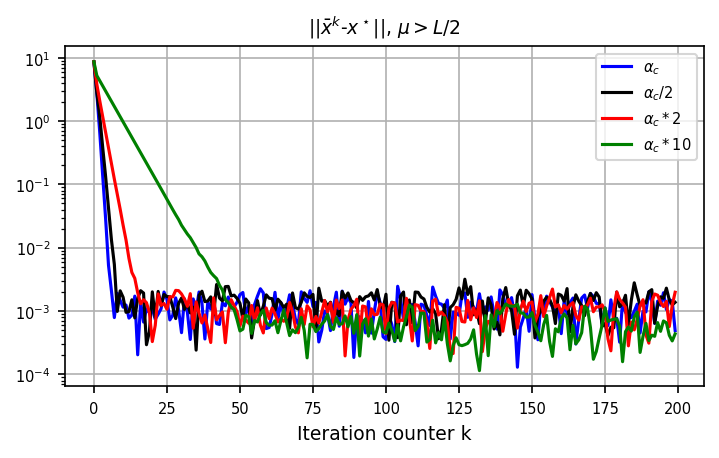

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 3), dpi=150)
ax = axs
# plt.figure(2)
ax.semilogy(res_all, color='blue', label=r'$\alpha_c$')
ax.semilogy(res_all2, color='black', label=r'$\alpha_c/2$')
ax.semilogy(res_all3, color='red', label=r'$\alpha_c*2$')
ax.semilogy(res_all4, color='green', label=r'$\alpha_c*10$')
ax.set_xlabel(r'Iteration counter k')
ax.grid()
ax.legend()
plt.title(r'||$\bar{x}^k$-$x^\star$||, $\mu > L/2$')
plt.savefig('quadTest_ConverRate.png')
plt.show()



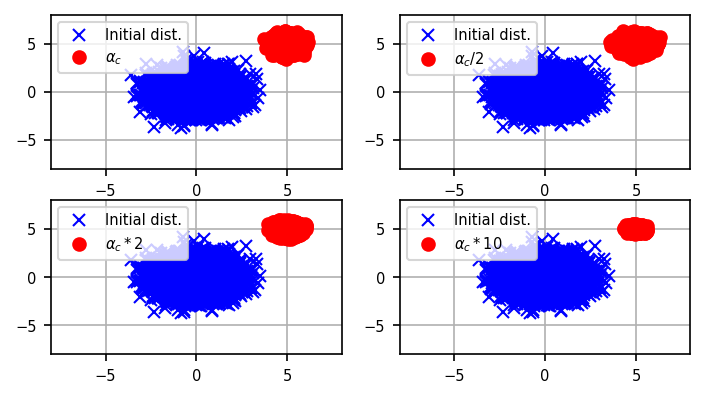

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5.5, 3), dpi=150)


ax = axs[0, 0]
ax.plot(x_all[0, 1:10000], x_all[1, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all[0, -10000:], x_all2[1, -10000:], 'o',label = r'$\alpha_c$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()

ax = axs[0, 1]
ax.plot(x_all2[0, 1:10000], x_all2[1, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all2[0, -10000:], x_all2[1, -10000:], 'o',label = r'$\alpha_c/2$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()

ax = axs[1, 0]
ax.plot(x_all3[0, 1:10000], x_all3[1, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all3[0, -10000:], x_all3[1, -10000:], 'o',label = r'$\alpha_c*2$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()

ax = axs[1, 1]
ax.plot(x_all4[0, 1:10000], x_all4[1, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all4[0, -10000:], x_all4[1, -10000:], 'o',label = r'$\alpha_c*10$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()


plt.savefig('XY_proj.png')
plt.show()


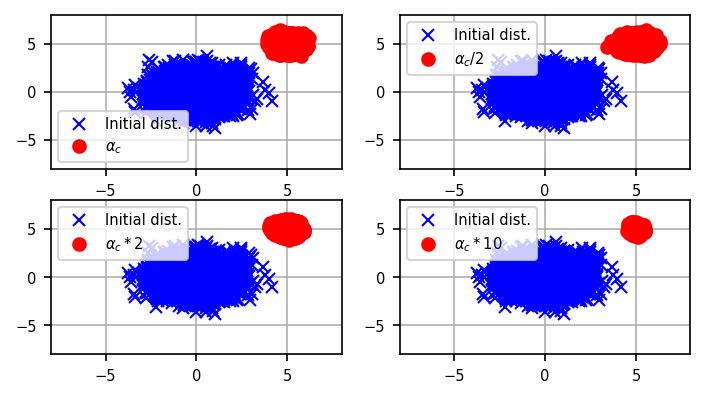

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5.5, 3), dpi=150)


ax = axs[0, 0]
ax.plot(x_all[1, 1:10000], x_all[2, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all[1, -10000:], x_all[2, -10000:], 'o',label = r'$\alpha_c$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()

ax = axs[0, 1]
ax.plot(x_all2[1, 1:10000], x_all2[2, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all2[1, -10000:], x_all2[2, -10000:], 'o',label = r'$\alpha_c/2$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()

ax = axs[1, 0]
ax.plot(x_all3[1, 1:10000], x_all3[2, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all3[1, -10000:], x_all3[2, -10000:], 'o',label = r'$\alpha_c*2$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()

ax = axs[1, 1]
ax.plot(x_all4[1, 1:10000], x_all4[2, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all4[1, -10000:], x_all4[2, -10000:], 'o',label = r'$\alpha_c*10$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()


plt.savefig('YZ_proj.png')
plt.show()

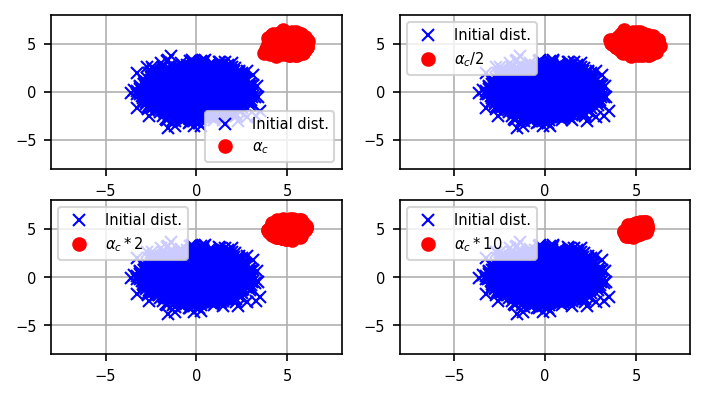

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5.5, 3), dpi=150)


ax = axs[0, 0]
ax.plot(x_all[0, 1:10000], x_all[2, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all[0, -10000:], x_all[2, -10000:], 'o',label = r'$\alpha_c$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()

ax = axs[0, 1]
ax.plot(x_all2[0, 1:10000], x_all2[2, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all2[0, -10000:], x_all2[2, -10000:], 'o',label = r'$\alpha_c/2$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()

ax = axs[1, 0]
ax.plot(x_all3[0, 1:10000], x_all3[2, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all3[0, -10000:], x_all3[2, -10000:], 'o',label = r'$\alpha_c*2$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()

ax = axs[1, 1]
ax.plot(x_all4[0, 1:10000], x_all4[2, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all4[0, -10000:], x_all4[2, -10000:], 'o',label = r'$\alpha_c*10$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()


plt.savefig('XZ_proj.png')
plt.show()

### Scenario 2 mu<L/2 - Post-processing

In [ ]:
alpha_crit = (mu + gamma_0 + np.sqrt(gamma_0**2 - 6*gamma_0*mu + mu**2 + 4*gamma_0*L))/(L - 2 *mu)
# alpha = alpha_c / 2 
alpha = ((mu+gamma_0+2*np.sqrt(gamma_0*L))/(L-mu))/2
x0 = x0s
v0 = x0
x_all2 = []
x_all2.append(x0)
res_all2 = []
for i in range(maxIter):
    eta = np.random.randn(n, nsamples)
    gamma1 = (gamma_0+mu*alpha)/(1+alpha) #since gamma_0 = mu, gamma_1 stays constant, let as it is for compliance
    x1 = (x0 + alpha*v0)/(1+alpha)
    tau = (alpha*mu)/gamma1
    v1 = (v0+tau*x1-alpha/gamma1*(A@(x1-rhs))+ sigma*np.sqrt(alpha)*eta)/(1+tau)
    x0 = x1
    v0 = v1 
    res_all2.append(np.linalg.norm(np.mean(x1, axis=1) - tar))
    x_all2.append(x1)

x_all2 = np.concatenate(x_all2, axis=1)

# alpha = (alpha_c + alpha_crit) / 2
alpha = (((mu+gamma_0+2*np.sqrt(gamma_0*L))/(L-mu))+alpha_crit)/2
x0 = x0s
v0 = x0
x_all3 = []
x_all3.append(x0)
res_all3 = []
for i in range(maxIter):
    eta = np.random.randn(n, nsamples)
    gamma1 = (gamma_0+mu*alpha)/(1+alpha) #since gamma_0 = mu, gamma_1 stays constant, let as it is for compliance
    x1 = (x0 + alpha*v0)/(1+alpha)
    tau = (alpha*mu)/gamma1
    v1 = (v0+tau*x1-alpha/gamma1*(A@(x1-rhs))+ sigma*np.sqrt(alpha)*eta)/(1+tau)
    x0 = x1
    v0 = v1 
    res_all3.append(np.linalg.norm(np.mean(x1, axis=1) - tar))
    x_all3.append(x1)

x_all3 = np.concatenate(x_all3, axis=1)

# alpha = 0.98 alpha_crit
alpha = 0.98*alpha_crit
x0 = x0s
v0 = x0
x_all4 = []
x_all4.append(x0)
res_all4 = []
for i in range(maxIter):
    eta = np.random.randn(n, nsamples)
    gamma1 = (gamma_0+mu*alpha)/(1+alpha) #since gamma_0 = mu, gamma_1 stays constant, let as it is for compliance
    x1 = (x0 + alpha*v0)/(1+alpha)
    tau = (alpha*mu)/gamma1
    v1 = (v0+tau*x1-alpha/gamma1*(A@(x1-rhs))+ sigma*np.sqrt(alpha)*eta)/(1+tau)
    x0 = x1
    v0 = v1 
    res_all4.append(np.linalg.norm(np.mean(x1, axis=1) - tar))
    x_all4.append(x1)

x_all4 = np.concatenate(x_all4, axis=1)

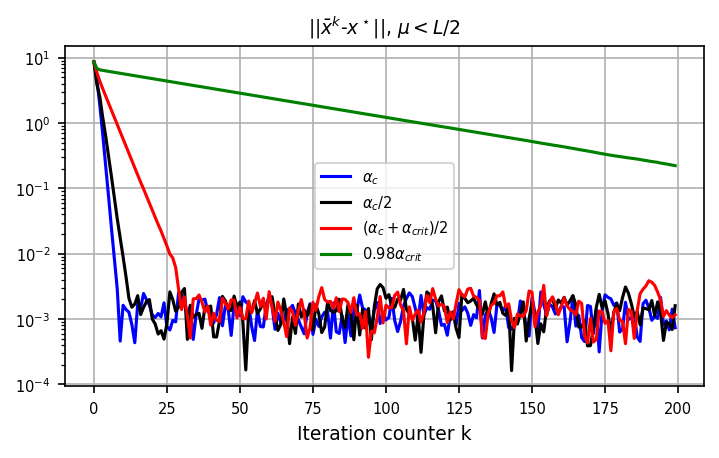

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 3), dpi=150)
ax = axs
ax.semilogy(res_all, color='blue', label=r'$\alpha_c$')
ax.semilogy(res_all2, color='black', label=r'$\alpha_c/2$')
ax.semilogy(res_all3, color='red', label=r'$(\alpha_c + \alpha_{crit})/2$')
ax.semilogy(res_all4, color='green', label=r'$0.98 \alpha_{crit}$')
ax.set_xlabel(r'Iteration counter k')
ax.grid()
ax.legend()
plt.title(r'||$\bar{x}^k$-$x^\star$||, $\mu < L/2$')
plt.savefig('quadTest_ConverRate.png')
plt.show()

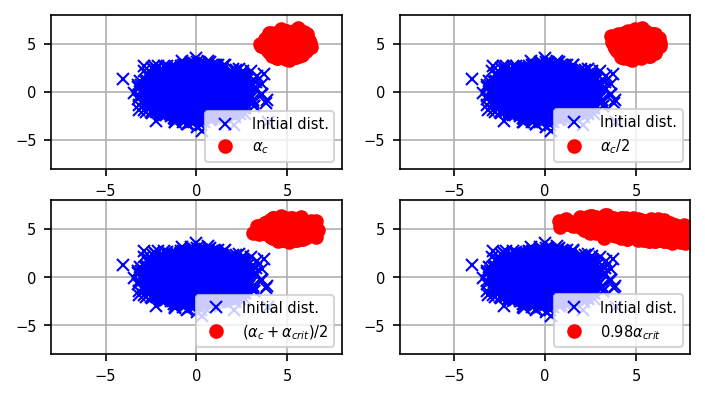

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5.5, 3), dpi=150)


ax = axs[0, 0]
ax.plot(x_all[0, 1:10000], x_all[1, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all[0, -10000:], x_all[1, -10000:], 'o',label = r'$\alpha_c$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()

ax = axs[0, 1]
ax.plot(x_all2[0, 1:10000], x_all2[1, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all2[0, -10000:], x_all2[1, -10000:], 'o',label = r'$\alpha_c/2$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()

ax = axs[1, 0]
ax.plot(x_all3[0, 1:10000], x_all3[1, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all3[0, -10000:], x_all3[1, -10000:], 'o',label=r'$(\alpha_c + \alpha_{crit})/2$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()

ax = axs[1, 1]
ax.plot(x_all4[0, 1:10000], x_all4[1, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all4[0, -10000:], x_all4[1, -10000:], 'o',label=r'$0.98 \alpha_{crit}$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()


plt.savefig('XY_proj.png')
plt.show()

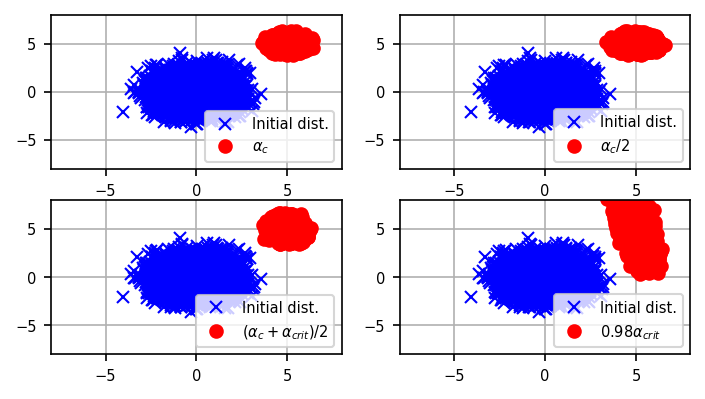

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5.5, 3), dpi=150)


ax = axs[0, 0]
ax.plot(x_all[1, 1:10000], x_all[2, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all[1, -10000:], x_all[2, -10000:], 'o',label = r'$\alpha_c$',color="red")
#plt.title("Distributions -YZ projection")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()

ax = axs[0, 1]
ax.plot(x_all2[1, 1:10000], x_all2[2, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all2[1, -10000:], x_all2[2, -10000:], 'o',label = r'$\alpha_c/2$',color="red")
#plt.title("Distributions -YZ projection")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()

ax = axs[1, 0]
ax.plot(x_all3[1, 1:10000], x_all3[2, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all3[1, -10000:], x_all3[2, -10000:], 'o',label=r'$(\alpha_c + \alpha_{crit})/2$',color="red")
#plt.title("Distributions -YZ projection")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()

ax = axs[1, 1]
ax.plot(x_all4[1, 1:10000], x_all4[2, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all4[1, -10000:], x_all4[2, -10000:], 'o',label=r'$0.98 \alpha_{crit}$',color="red")
#plt.title("Distributions -YZ projection")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()


plt.savefig('YZ_proj.png')
plt.show()

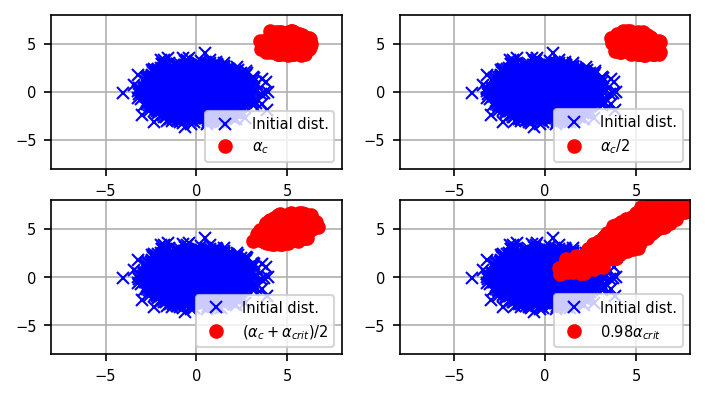

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5.5, 3), dpi=150)


ax = axs[0, 0]
ax.plot(x_all[0, 1:10000], x_all[2, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all[0, -10000:], x_all[2, -10000:], 'o',label = r'$\alpha_c$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()

ax = axs[0, 1]
ax.plot(x_all2[0, 1:10000], x_all2[2, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all2[0, -10000:], x_all2[2, -10000:], 'o',label = r'$\alpha_c/2$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()

ax = axs[1, 0]
ax.plot(x_all3[0, 1:10000], x_all3[2, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all3[0, -10000:], x_all3[2, -10000:], 'o',label=r'$(\alpha_c + \alpha_{crit})/2$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()

ax = axs[1, 1]
ax.plot(x_all4[0, 1:10000], x_all4[2, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all4[0, -10000:], x_all4[2, -10000:], 'o',label = r'$0.98 \alpha_{crit}$',color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()
ax.legend()


plt.savefig('XZ_proj.png')
plt.show()

### NAG-FI scheme

**Full implicit shemes**

Let us start with the model:

$$
\begin{split}
&\frac{dx}{dt} = v - x, \\
&\frac{dv}{dt} = \frac{\mu}{\gamma} (x - v) - \frac{1}{\gamma} A x + \frac{dZ}{dt}.
\end{split} 
$$

Given step size $\alpha_k > 0$, we consider the fully-implicit scheme as follows:

$$
\begin{split}
&\frac{x_{k+1}-x_k}{\alpha_k} = v_{k+1} - x_{k+1}, \\
&\frac{v_{k+1}-v_k}{\alpha_k} = \frac{\mu}{\gamma_k} (x_{k+1} - v_{k+1}) - \frac{1}{\gamma_k} A x_{k+1} + \sigma \frac{W_{k+1}-W_k}{\alpha_k}.
\end{split} 
$$

which equivalent to solve:
$\begin{bmatrix} x_k \\ v_k + \sigma \sqrt{\alpha_k} \eta_k \end{bmatrix}=\begin{bmatrix} (1+\alpha_k)I& -\alpha_k I \\ \frac{\alpha_k}{\gamma_k}(A-\mu I) &  (1+\frac{\alpha_k \mu}{\gamma_k})I \end{bmatrix} \begin{bmatrix} x_{k+1} \\ v_{k+1} \end{bmatrix}$.

Finally we get the following iterative scheme:

Given $\sigma$, $\gamma_0 := \mu$, $\alpha_k>0$ for all $k$, $v_0=0$ and $x_0$ randomly generated using mutli-variate normal distribution:

1. Sample $\eta_k \sim \mathcal{N}(0,1)$ 
2. $\gamma_{k+1}:=\frac{\gamma_k+\alpha_k \mu}{1+\alpha_k}$ (let it if variable time step is used later)
3. Pose: $b=\begin{bmatrix} x_k \\ v_k + \sigma \sqrt{\alpha_k} \eta_k \end{bmatrix}$, $G=\begin{bmatrix} (1+\alpha_k)I& -\alpha_k I \\ \frac{\alpha_k}{\gamma_k}(A-\mu I) &  (1+\frac{\alpha_k \mu}{\gamma_k})I \end{bmatrix}$ and $x=\begin{bmatrix} x_{k+1} \\ v_{k+1} \end{bmatrix}$
4. Compute [L,U,P]-decomposition of $G$
5. Solve $Pb = Ly$ (forward substitution)
6. Solve $Ux = y$  (backward substitution) 


Note that for the numerical tests presented after, the objective function considered is $f(x)=\frac{1}{2}(x^T-5*e) A (x-5*e)$ with $e$ a all-ones column vector of size $d$. Hence the target distribution towards we expect to converge is a Gaussian distribution of mean $5*e$.

In [ ]:
# solver parameters
alpha1 = 2.0/np.sqrt(np.linalg.cond(A))
alpha2 = (mu+gamma_0+2*np.sqrt(gamma_0*L))/(L-mu)
alpha=np.max([alpha1,alpha2])
alpha = alpha*1000
nsamples = 200000
gamma_0 = np.sqrt(mu)
sigma = 1
maxIter = 100
c = 5

# Vectors init
x0 = np.random.randn(n, nsamples)
v0 = np.zeros((n, nsamples))
x = np.zeros((2*n, nsamples))
w0 = np.concatenate((x0, v0), axis=0)
x_all = []
res_all = []
x_all.append(x0)

rhs = np.ones((n, nsamples))*c
tar = rhs[:, 0]
Id = np.identity(n)

# NAG-FI - Algorithm 3
for i in range(maxIter):
    eta = np.random.randn(n, nsamples)
    gamma1 = (gamma_0+mu*alpha)/(1+alpha)
    G = np.block([
        [(1+alpha)*Id,               -alpha*Id],
        [alpha/gamma1*(A-mu*Id), (1+alpha*mu/gamma1)*Id               ]
        ])
    b = np.block([
        [x0          ],
        [v0+sigma*np.sqrt(alpha)*eta+alpha/gamma1*A@rhs]
        ])
    x = np.linalg.inv(G)@b #TO DO: implement LU decomposition for for+back-ward susbstitution, or simply: compute once the inverse since....constant step size and gamma_0=mu
    x1 = x[0:n,:]
    v1 = x[n:2*n,:]
    x0 = x1
    v0 = v1 
    res_all.append(np.linalg.norm(np.mean(x1, axis=1) - rhs[:,0]))
    x_all.append(x1)

x_all = np.concatenate(x_all, axis=1)

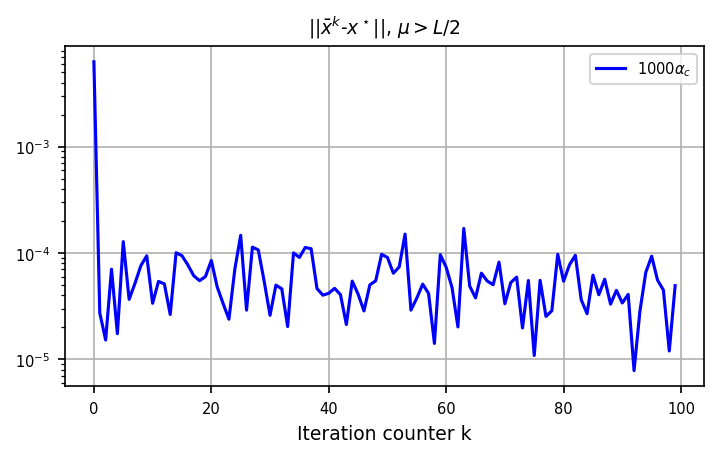

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 3), dpi=150)
ax = axs
ax.semilogy(res_all, color='blue', label=r'$1000 \alpha_c$')
ax.set_xlabel(r'Iteration counter k')
ax.grid()
ax.legend()
plt.title(r'||$\bar{x}^k$-$x^\star$||, $\mu > L/2$')
#plt.savefig('quadTest_NAGFIConverRate.png')
plt.show()

In [ ]:
np.mean(x_all[:, -10000:], axis=1)

array([5.00004558, 4.99985365, 5.00015644])

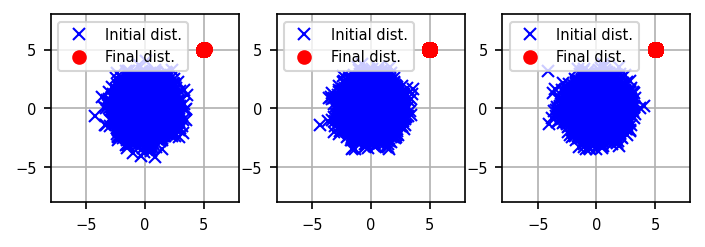

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(5.5, 3), dpi=150)

ax = axs[0]
ax.plot(x_all[0, 1:10000], x_all[1, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all[0, -10000:], x_all[1, -10000:], 'o',label = "Final dist.",color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_aspect('equal', 'box')
ax.grid()
ax.legend()

ax = axs[1]
ax.plot(x_all[0, 1:10000], x_all[2, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all[0, -10000:], x_all[2, -10000:], 'o',label = "Final dist.",color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_aspect('equal', 'box')
ax.grid()
ax.legend()

ax = axs[2]
ax.plot(x_all[1, 1:10000], x_all[2, 1:10000], 'x',label = "Initial dist.",color="blue")
ax.plot(x_all[1, -10000:], x_all[2, -10000:], 'o',label = "Final dist.",color="red")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_aspect('equal', 'box')
ax.grid()
ax.legend()


plt.savefig('NAGFI_projs.png')
plt.show()

# *Non-convex setting* 
The following extends the tests performed in previous sections for the non-convex setting. 
The objective function is the following:
$f(x)=\frac{1}{2}\|A u - b \|_F^2$ where $A \in \mathbb{R}^{m \times n}$, $b \in \mathbb{R}^{m}$ and $u_i=\log \cosh (x_i)$ for $1 \leq i \leq n$.

Let us intuitively replace $Ax_{k+1}$ by $\nabla f(x_{k+1})$, we get the following semi-implicit scheme with step size $\alpha_k > 0$:

$$
\begin{split}
&\frac{x_{k+1}-x_k}{\alpha_k} = v_k - x_{k+1}, \\
&\frac{v_{k+1}-v_k}{\alpha_k} = \frac{\mu}{\gamma_k} (x_{k+1} - v_{k+1}) - \frac{1}{\gamma_k} \nabla f (x_{k+1}) + \sigma \frac{W_{k+1}-W_k}{\alpha_k}.
\end{split} 
$$

where $\nabla f(x)=[Q u - c]\odot w$ with $Q=A^T A$, $c=A^T b$ and $w_i=\tanh (x_i)$ for $1 \leq i \leq n$.

The first scheme tested here-under is the NAG-GS (with $\gamma_0 = \mu$ and constant step size), see Algorithm 1 from paper.

In [ ]:
# Libraries import
import jax.numpy as jnp
from jax import grad, vmap, jit
import jax
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lu
import math
import scipy.integrate as integrate
from scipy.stats import gaussian_kde
import tensorflow as tf

In [ ]:
# Initialization
A = np.diag([1.0, 1.0, 5.0])
n = A.shape[0]
nsamples = 200000
mu = np.min(np.linalg.eigvals(A))
b = np.ones((n, nsamples))*3
Q = np.dot(np.transpose(A),A)
c = np.dot(np.transpose(A),b)
x0 = np.random.randn(n, nsamples)#+np.ones((n, nsamples))*3
v0 = np.zeros((n, nsamples))
w0 = np.concatenate((x0, v0), axis=0)
x_all_NAG = []
x_all_NAGI = []
x_all_NAG.append(x0)
x_all_Euler = []
x_all_Euler.append(x0)
gamma_0 = np.sqrt(mu)

# Parameters

alpha_NAG = 2.0/np.sqrt(np.linalg.cond(A))
alpha_Euler = 1/np.max(np.linalg.eigvals(A))
maxIter_NAG = 200
maxIter_Euler = 200
maxIter_NAGI = 20
sigma = 1 # PLAY with sigma to see the effect on the final distribution, ex:sigma=1/2
alpha_NAG = alpha_NAG * 0.6
alpha_Euler = alpha_Euler * 0.4
alpha_NAGI = alpha_NAG

# Library of in house tools

def lossfun(x,A=A,b=b[:,0]):
    b = b.squeeze()
    x = x.squeeze()
    res = A@jnp.log(jnp.cosh(x))-b
    return 1/2*res.T @ res

def gradlossfun(x,Q,c):
    logcosh = jnp.log(jnp.cosh(x))
    return jnp.multiply((Q+jnp.transpose(Q))/2@logcosh-c, jnp.tanh(x))

def Hesslossfun(x,Q,c,n):
    logcosh = jnp.log(jnp.cosh(x))
    ctanh = jnp.tanh(x)
    csech = jnp.divide(jnp.ones((n, 1)).T,jnp.cosh(x))
    fac1 = jnp.multiply(Q@logcosh-c,csech**2)
    fac1 = jnp.diag(fac1.squeeze(), k=0)
    res = fac1+jnp.multiply(Q,jnp.tensordot(ctanh, ctanh, axes=0))
    return res.squeeze()

def Jacobianfun(x,Q,c,n,alpha,gamma,tau):
    I = jnp.identity(n)
    return I+alpha/(gamma*(1+tau))*Hesslossfun(x,Q,c,n)

def fun_g(u,xk,vk,tau,alpha,gamma,sigma,etak,Q,c):
    gradf = gradlossfun(u,Q,c)
    res = u-(vk+tau*xk-alpha/gamma*gradf+sigma*jnp.sqrt(2*alpha)*etak)/(1+tau)
    return res

def NewtonRaphson_oneIt(u,xk,vk,tau,alpha,gamma,sigma,etak,Q,c,n):
    g_val = fun_g(u,xk,vk,tau,alpha,gamma,sigma,etak,Q,c)
    J = Jacobianfun(u,Q,c,n,alpha,gamma,tau)
    #print(jnp.amax(jnp.abs(g_val)))
    return u-jnp.linalg.inv(J)@g_val.T



In [ ]:
print(alpha_NAG)
print(alpha_Euler)

0.5366563145999494
0.08000000000000002


In [ ]:
# Solver benchmark
x0_NAG = x0
x0_Euler = x0
v0=x0_NAG # can be commented, no impact on results
# Euler-Maruyama method is also considered for comparison
# NAG-GS scheme
for i in range(maxIter_NAG):
    # Generation of Brownian motion
    eta = np.random.randn(n, nsamples)
    gamma1 = (gamma_0+mu*alpha_NAG)/(1+alpha_NAG)
    x1_NAG = (x0_NAG + alpha_NAG*v0)/(1+alpha_NAG)
    tau = (alpha_NAG*mu)/gamma1
    gradf = gradlossfun(x1_NAG,Q,c)
    v1 = (v0+tau*x1_NAG-alpha_NAG/gamma1*(gradf)+ sigma*np.sqrt(2*alpha_NAG)*eta)/(1+tau) # a 2 has been considered within the sqrt, for test
    x0_NAG = x1_NAG
    v0 = v1 
    x_all_NAG.append(x1_NAG)

# Euler scheme
for i in range(maxIter_Euler):
    # Generation of Brownian motion
    eta = np.random.randn(n, nsamples)
    gradf = gradlossfun(x0_Euler,Q,c)
    x1_Euler = x0_Euler - alpha_Euler*gradf + np.sqrt(2*sigma*alpha_Euler)*eta
    x0_Euler = x1_Euler
    x_all_Euler.append(x1_Euler)


# Gathering of points
x_all_NAG_format = np.concatenate(x_all_NAG, axis=1)
x_all_Euler_format = np.concatenate(x_all_Euler, axis=1)

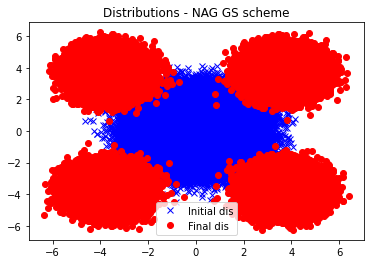

In [ ]:
plt.plot(x_all_NAG_format[0, 1:nsamples], x_all_NAG_format[1, 1:nsamples], 'x',label = "Initial dis",color="blue")
plt.plot(x_all_NAG_format[0, -nsamples:], x_all_NAG_format[1, -nsamples:], 'o',label = "Final dis",color="red")
plt.title("Distributions - NAG GS scheme")
plt.legend()
plt.show()

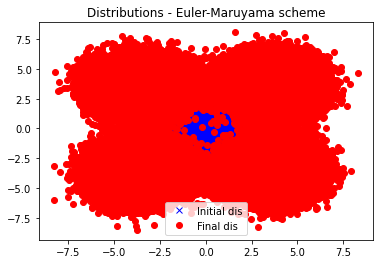

In [ ]:
plt.plot(x_all_Euler_format[0, 1:nsamples], x_all_Euler_format[1, 1:nsamples], 'x',label = "Initial dis",color="blue")
plt.plot(x_all_Euler_format[0, -nsamples:], x_all_Euler_format[1, -nsamples:], 'o',label = "Final dis",color="red")
plt.title("Distributions - Euler-Maruyama scheme")
plt.legend()
plt.show()

**Full implicit shemes**

Let us start with the model:

$$
\begin{split}
&\frac{dx}{dt} = v - x, \\
&\frac{dv}{dt} = \frac{\mu}{\gamma} (x - v) - \frac{1}{\gamma} \nabla f( x) + \frac{dZ}{dt}.
\end{split} 
$$

Given step size $\alpha_k > 0$, we consider the fully-implicit scheme as follows:

$$
\begin{split}
&\frac{x_{k+1}-x_k}{\alpha_k} = v_{k+1} - x_{k+1}, \\
&\frac{v_{k+1}-v_k}{\alpha_k} = \frac{\mu}{\gamma_k} (x_{k+1} - v_{k+1}) - \frac{1}{\gamma_k} \nabla f(x_{k+1}) + \sigma \frac{W_{k+1}-W_k}{\alpha_k}.
\end{split} 
$$

where $\nabla f(x)=[Q \log \cosh (x) - c]\odot \tanh (x)$ with $Q=A^T A$, $c=A^T b$ and $∇^2f(x)=\text{diag}\left(\left(Q \log \cosh(x)-c\right)\odot (\sech(x))^{.2}\right) + Q \odot \left(\tanh(x) \tanh(x)^T \right)$
with functions $\log \cosh(.)$, $\tanh(.)$ and $\sech(.)$ applied element-wise to input vector.


The second scheme tested here-under is the NAG-FI ($\gamma_0 = \mu$ and constant step size), see Algorithm 3 from paper.



In [ ]:
# Solver benchmark
x0_NAGI = x1_NAG #x0 - x1_NAG
v0=v1 # can be commented, no impact on results #v1 - v0
x_all_NAGI.append(x0_NAGI)
maxIter_NR = 20
alpha_NAGI=alpha_NAG*100
# NAGI scheme
for i in range(maxIter_NAGI):
    # Generation of Brownian motion
    eta = np.random.randn(n, nsamples)
    # Update of optimization parameters
    gamma1 = (gamma_0+mu*alpha_NAGI)/(1+alpha_NAGI)
    # Update of x1_NAGI - Newton Raphson
    tau = 1/alpha_NAGI+mu/gamma1
    u = x0_NAGI
    for k in range(maxIter_NR):
      #print(k)
      u=vmap(NewtonRaphson_oneIt, in_axes=(0,0,0, None, None, None, None, 0,None, None, None))(u.T, x0_NAGI.T, v0.T,  tau,alpha_NAGI,gamma1,sigma,eta.T,Q,c[:,0],n)
      u=u.T

    x1_NAGI = u
    # Update of v1
    v1 = (x1_NAG-x0_NAGI)/alpha_NAGI + x1_NAGI
    # Update for next iteration
    x0_NAGI = x1_NAGI
    v0 = v1 
    x_all_NAGI.append(x1_NAGI)


In [ ]:
x_all_NAGI_format = np.concatenate(x_all_NAGI, axis=1)

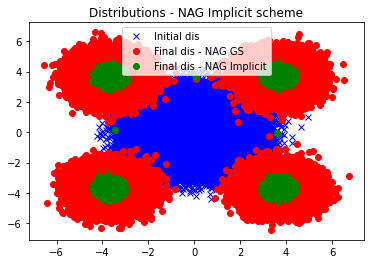

In [ ]:
plt.plot(x_all_NAG_format[0, 1:nsamples], x_all_NAG_format[1, 1:nsamples], 'x',label = "Initial dis",color="blue")
plt.plot(x_all_NAG_format[0, -nsamples:], x_all_NAG_format[1, -nsamples:], 'o',label = "Final dis - NAG GS",color="red")
plt.plot(x_all_NAGI_format[0, -nsamples:], x_all_NAGI_format[1, -nsamples:], 'o',label = "Final dis - NAG FI",color="green")
plt.title("Distributions - NAG Implicit scheme")
plt.legend()
plt.show()